# Actividad 3: RNN y sus aplicaciones en las series temporales

En esta actividad se va a aplicar el conocimiento adquirido sobre las RNN para entrenar modelos que sean capaces de predecir el comportamiento de las series temporales. Para ello, se usará un dataset de temperaturas para mediante la aplicación de RNN, predecir los valores futuros que tendrá la serie temporal que se tiene. Este trabajo se suele hacer mediante modelos ARIMA, pero en esta práctica se verá cómo el modelado mediante RNN es una opción muy buena en estos casos de series temporales.

**1. Descargar el dataset y almacenarlo**

En primer lugar hay que importar tensorflow.

In [ ]:
import tensorflow as tf
print(tf.__version__)

: 

El siguiente paso es importar las bibliotecas numpy y matplotlib. Además, se define el método **plot_series** que se utilizará para hacer las gráficas de las series temporales.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

: 

A continuación se descarga el dataset de las temperaturas mínimas diarias.

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2022-06-12 15:18:53--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2022-06-12 15:18:53 (5.78 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



: 

En este paso, se utilizará la biblioteca csv de Python para guardar y poder leer el dataset de temperaturas mínimas diarias que ha sido descargado en el paso anterior. Además, se construye la variable **series** que será donde se guarde la serie temporal. Por último, siempre que se trate con una serie temporal, es una buena práctica hacer un gráfico para poder verla y tener una idea de cómo es.

: 

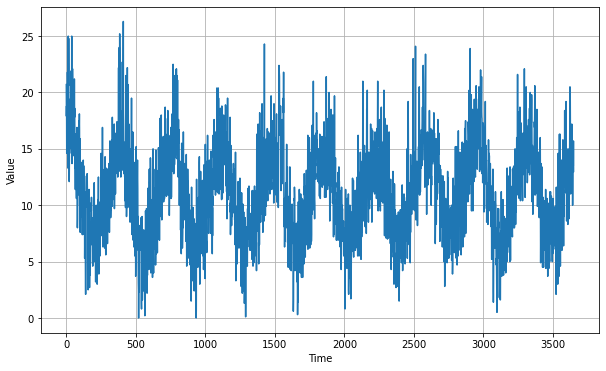

: 

In [ ]:

import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

# 2. Creación de las variables necesarias para el diseño de la red neuronal

Una técnica muy común cuando se trata con series temporales es utilizar una ventana temporal que se vaya desplazando sobre la serie temporal para reducir su análisis a lo que ocurre en ese ventana de forma local, para a continuación realizar el modelado global.

**Ejercicio 1 (0.4 puntos)**: Crear las variables de entrenamiento y validación y hacer la partición de las mismas. Las variables que hay que crear son:

*   time_train
*   x_train
*   time_valid
*   x_valid





In [ ]:
## variables para la técnica de la ventana temporal
split_time = 2500
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

## Split del dataset en entrenamiento y validación
import math
time_train=0.8
x_train=0.8
time_valid=1-time_train
x_valid=1-x_train

st,sv=series[:time_train*x_train],series[time_train*x_valid:]
tt,tv=time[:time_train*time_train],time[time_train*time_valid:]
## tu código para la creación de las 4 variables del ejercicio 1 aquí

: 

2. Creación del método **windowed_datset** para poder utilizarlo en el modelo. Las entradas por parámetros del método son:

*   series
*   window_size
*   batch_size
*   shuffle_buffer

El resto de elementos que se usan para construir la función ventana temporal para explorar el dataset, son métodos de Python para tratar con series temporales.




# 3. Diseño de la función para predecir los siguientes valores de la serie temporal usando la técnica de la ventana temporal

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

: 

A continuación, y usando como modelo el método **windowed_dataset** se procederá a adaptar el método **model_forecast** que se usará para predecir los siguientes valores de la serie temporal utilizando la técnica de la ventana temporal.

**Ejercicio 2 (1.6 puntos)**: completar el método model_forecast creando los elementos necesarios dentro del método:

1.   Crear la variable **ds** y darle el valor resultante del método **from_tensor_slices** pasando por parametro **series** **(0.4 puntos)**
2.   Actualizar la ventana (**window**) de la variable **ds** (nota: en este caso el tamaño es el mismo de la ventana, no es necesario que sea window_size+1) **(0.4 puntos)**
3.   Crear el **flat_map** de la variable, teniendo en cuenta que el tamaño es **window_size** **(0.4 puntos)**
4.   Añadir la siguiente linea de código: ds = ds.batch(32).prefetch(1)
5.   Crear la variable **forecast** en la que se usará el método **predict** **(0.4 puntos)**
6.   Por último, se devolverá la variable forecast.




In [ ]:
def model_forecast(model, series, window_size):
  ds=tf.data.Dataset.from_tensor_slices((st,tt))
  ds=windowed_dataset(ds, window_size, batch_size, shuffle_buffer_size)
## tu código para el método model_forecast del ejercicio 2 aquí

: 

A continuación, se limpia la sesión de keras, y se inicializan las variables necesarias para poder diseñar el modelo de series temporales a entrenar usando RNN.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

: 

# 4. Diseño de la red neuronal

**Ejercicio 3.1 (0.5 puntos)**: Hay que crear la variable **train_set** dandole el valor que se reciba del método **windowed_datset**, los parametros que debe recibir este método son: **x_train, window_size, batch_size, shuffle_buffer_size**

In [ ]:
## tu código aquí para el ejercicio 3

: 

**Ejercicio 3.2 (4 puntos)**: Se debe construir la red neuronal de aprendizaje profunda basada para modelar la serie temporal de las temperaturas minimas diarias. Esta red neuronal debera contar con las siguientes capas ocultas:

1.   Una capa de convolución en una dimensión que tenga 32 filtros, una tamaño del kernel de 5, un stride de 1, padding "causal", la función de activación debe ser relu y el input shape debe ser [None, 1] 
2.   Una capa LSTM con 64 neuronas y retorno de secuencias 
3.   Una capa LSTM con 64 neuronas y retorno de secuencias 
4.   Una capa densa con 30 neuronas
5.   Una capa densa con 10 neuronas
6.   Una capa densa con 1 neuronas
7.   Por último, se añade la siguiente capa: tf.keras.layers.Lambda(lambda x: x * 400)




In [ ]:
## tu código para la red neuronal del ejercicio 4 aquí

: 

# 5. Entrenamiento de la red neuronal

**Ejercicio 4 (0.5 puntos)**: Se va a diseñar un método callbacks para el learning rate que será guardado en la variable **lr_schedule**, este método deberá usar el método **LearningRateScheduler** de Python y será una función **lambda** que le de el valor a epoch de 1e-8 * 10**(epoch / 20) **texto en negrita** 

In [ ]:
## tu código para crear la variable lr_schedule aquí


: 

**Ejercicio 5 (1.5 puntos):** Compilar la red neuronal con los siguientes parametros:

*   loss: método Huber de keras
*   El optimizador debe ser el SGD con learning rate 1e-8 y momentum 0.9
*   La métrica a visualizar es el error absoluto medio (medium absolute error en ingles)



In [ ]:
## tu código para compilar la red neuronal para el ejercicio 5 aquí

: 

Para terminar se entrena el modelo previamente diseñado y compilado en los pasos anteriores.

In [ ]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

NameError: ignored

: 

# 6. Actualización del learning rate según los resultados obtenidos del primer entrenamiento de la red neuronal

Después del entrenamiento de la red neuronal se ve que learning rate resultante es de 1e-5. Se visualizará gráficamente para entender el motivo por el que se ha usado ese valor. En la gráfica se puede ver cómo el learning rate con el que menos loss hay es 1e-5, y por ese motivo, se debe volver a entrenar la red neuronal con dicho learning rate.

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

: 

Se vuelve a inicializar la sesión de entrenamiento y la variable train_set:

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

: 

**Ejercicio 6 (0.5 puntos)**: Para crear el nuevo modelo, reutiliza la red neuronal diseñada en el ejercicio 4, pero esta vez utilizando 60 filtros en la capa de convolución.

In [ ]:
## tu código para la red neuronal del ejercicio 6 aquí

: 

**Ejercicio 7 (0.5 puntos)**: Se debe volver a compilar la red neuronal de manera análoga a la del ejercicio 5, pero esta vez utilizar un learning rate obtenido de la función callback.

In [ ]:
## tu código para compilar la red neuronal para el ejercicio 7 aquí

: 

In [ ]:
history = model.fit(train_set,epochs=150)

: 

# 7. Predicción de los siguientes valores de la serie temporal

Para concluir la actividad, se usa el método model_forecast que se ha diseñado utilizando el método de la ventana temporal para hacer el nuevo metodo rnn_forecast con el cual se calcularán los nuevos valores de la serie temporal. Posteriormente, se pinta una gráfica para ver esos resultados y comprobar de forma visual que son correctos. Además, se dan los resultados de esas predicciones en forma númerica, de esta forma, este modelo diseñado en esta actividad podría ser el input de un nuevo algoritmo si fuera necesario.

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

: 

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

: 

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

: 

In [ ]:
print(rnn_forecast)

: 

# 8. Mostrar gráficamente los resultados.

Una vez obtenido el resultado de la actividad, se procede a revisr de forma gráfica el training y validation loss a lo largo de los epochs en este nuevo entrenamiento con el learning rate optimizado.

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Recuperar una lista de resultados de la lista de datos de entrenamiento y pruebas para cada epoch de entrenamiento
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

: 

A continuación se realiza el plot de la pérdida frente a los epochs

In [ ]:
#------------------------------------------------
# Pérdida de entrenamiento y validación por epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

: 

**Ejercicio 8 (0.5 punto)**: Utilizando las 2 nuevas variables zoomed_loss y zoomed_epochs y con base en el código anterior, hacer el plot del loss frente a los epochs entre los epoch 20 y 150 para ver como va oscilando y no es un proceso lineal como podria parecer según el anterior plot.

In [ ]:
#------------------------------------------------
# Pérdida de entrenamiento y validación por epoch con zoom
#------------------------------------------------
zoomed_loss = loss[20:]
zoomed_epochs = range(20,150)
#
## tu código para el plot con zoom del ejercicio 8 aquí

: 